<a href="https://colab.research.google.com/github/BernardoRMendes/Projeto/blob/main/Estimadores_Volatilidade_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
!pip install yahooquery

     |████████████████████████████████| 51kB 3.2MB/s 
     |████████████████████████████████| 81kB 4.6MB/s 
     |████████████████████████████████| 6.3MB 9.5MB/s 
  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp37-none-any.whl size=7012 sha256=394c4c3413f63ddc93b355123a6f02f63f79fd928ecc59cbeba3948d353de5f5
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


**Para medir a volatilidade histórica, é comum calcular o desvio padrão dos retornos diários. No entanto, essa é uma medida que desconsidera as dinâmicas intraday. Imagine, por exemplo, uma ação que tenha fechamento do dia atual igual ao fechamento do dia anterior, mas que durante o dia oscilou 5%. Nessa situação, o indicador close-to-close não medirá a volatilidade com eficiência. Dessa forma, surgiram vários estimadores, cada um com seus pontos fortes e fracos, que auxiliam no cálculo da verdadeira volatilidade histórica.**

**Alguns desses estimadores são:**

**Close-to-Close (C): É a medida de volatilidade histórica mais comum, utiliza apenas dados de fechamento.**

**Parkinson (HL) O primeiro estimador de volatilidade mais avançado surgiu em 1980, criado por Parkinson. Em vez de usar os preços de fechamento, utiliza as máximas e mínimas. Um ponto fraco do estimador é a premissa de mercados contínuos, o que leva a subestimar a volatilidade, pois movimentos como Gaps entre dias diferentes são ignorados.**

**Garman-Klass (OHLC): Esse estimador é uma extensão de Parkinson, adicionando os preços de abertura e fechamento em seus cálculos. Como Gaps entre os dias são ignorados, também subestima a volatilidade.**

**Garman-Klass-Yang-Zhang (OHLC): É uma extensão do estimador anterior, pois considera os saltos entre a abertura de um dia em relação ao fechamento do dia anterior.**

**Rogers-Satchell (OHLC): O estimador de Rogers-Satchell foi criado no início da década de 90. É capaz de medir adequadamente a volatilidade com drift diferente de zero. No entanto, ainda não lida com saltos, subestimando a volatilidade.**

**Yang-Zhang (OHLC): Em 2000, Yang-Zhang criaram o estimador mais poderoso, que lida tanto com Gaps de abertura quanto drift diferente de zero. É a soma da volatilidade do fechamento até a abertura do dia seguinte com a média ponderada do estimador de Rogers-Satchell e da volatilidade da abertura até o fechamento de um mesmo dia.**


**Nesse estudo, calculei a volatilidade em janelas móveis de 30 dias para o ibovespa em Python desde junho/2014 até abril/2021.**

**Importação do pacote do Yahoo e selecionando o código do Ibovespa (^bvsp"):**

In [2]:
from yahooquery import Ticker
ibov = Ticker("^bvsp")

**Fazendo o upload das fórmulas do estimadores:**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving estimadoresvol.jpg to estimadoresvol.jpg


**Código para mostrar a imagem:**

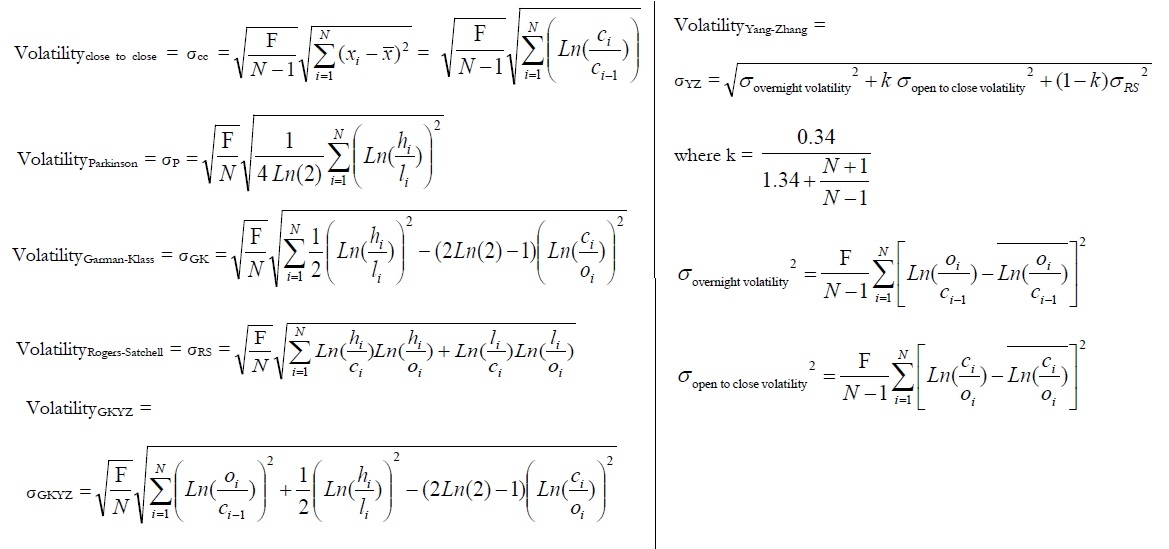

-1

In [4]:
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('estimadoresvol.jpg')
cv2_imshow(img)
cv2.waitKey()

**Na Imagem, F é igual à frequência de retornos em um ano (252 para retornos diários, por exemplo).**

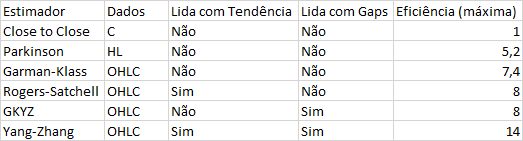

**C - Dados de Fechamento**

**H - Dados de Máxima**

**L - Dados de Mínima**

**O - Dados de Abertura**

**Eficiência: Compara a variância de um estimador em relação à variância do estimador Close-to-Close.**

**Mais detalhes podem ser encontrados no material:** https://dynamiproject.files.wordpress.com/2016/01/measuring_historic_volatility.pdf

**Importando as cotações do Ibovespa de 01/06/2014 até 01/05/2021, com periodicidade diária. Observe que os dados são colocados em um dataframe.**

In [5]:
df=ibov.history(start="2014-06-01",end="2021-05-01",interval='1d')
type(df)

pandas.core.frame.DataFrame

**Número de linhas e colunas:**

In [6]:
df.shape

(1707, 6)

**Verificando se há valores nulos:**

In [7]:
df.isnull().sum()

low         0
open        0
high        0
close       0
volume      0
adjclose    0
dtype: int64

In [8]:
df.dropna(inplace=True)

**Primeiras linhas do DataFrame:**

In [9]:
df.head()

low     open     high    close     volume  adjclose
symbol date                                                               
^bvsp  2014-06-02  51239.0  51239.0  51879.0  51606.0  2597900.0   51606.0
       2014-06-03  51377.0  51606.0  52032.0  52032.0  2859400.0   52032.0
       2014-06-04  51609.0  52032.0  52032.0  51833.0  2571500.0   51833.0
       2014-06-05  51470.0  51833.0  52245.0  51559.0  2890000.0   51559.0
       2014-06-06  51562.0  51562.0  53175.0  53129.0  4298400.0   53129.0

**Selecionando apenas as colunas de interesse (open,low,high,close), que correspondem aos dados de abertura, mínima, máxima e fechamento, respectivamente.**

In [10]:
df=df[["open","low","high","close"]]

In [11]:
df

open       low      high     close
symbol date                                              
^bvsp  2014-06-02   51239.0   51239.0   51879.0   51606.0
       2014-06-03   51606.0   51377.0   52032.0   52032.0
       2014-06-04   52032.0   51609.0   52032.0   51833.0
       2014-06-05   51833.0   51470.0   52245.0   51559.0
       2014-06-06   51562.0   51562.0   53175.0   53129.0
...                     ...       ...       ...       ...
       2021-04-26  120534.0  119860.0  121393.0  120595.0
       2021-04-27  120595.0  119003.0  121012.0  119388.0
       2021-04-28  119392.0  119392.0  121276.0  121053.0
       2021-04-29  121053.0  119703.0  121498.0  120066.0
       2021-04-30  120064.0  118894.0  120125.0  118894.0

[1707 rows x 4 columns]

**Nas funções abaixo, "df" é o dataframe com dados de abertura, mínima, máxima e fechamento e "n" é a janela móvel usada para o cálculo da volatilidade. O termo "np.sqrt(252)*100" anualiza os resultados.**

**df["close"] é a coluna do Dataframe com os dados de fechamento diário.**

**df['high'] é a coluna do Dataframe com os dados de máxima diária.**

**df['low'] é a coluna do Dataframe com os dados de mínima diária.**

**df['open'] é a coluna do Dataframe com os dados de abertura diária.**



In [12]:
def close_to_close(df,n):
  df["C/C(-1)-1"]=df['close']/df['close'].shift(1)-1
  df["Close-to-Close"]=df["C/C(-1)-1"].rolling(n).std()*np.sqrt(252)*100
  return df["Close-to-Close"]

In [13]:
def Garman_Klass(df,n):
  df["log^2(H/L)"]=(np.log(df['high']/df['low']))**2
  df["log^2(C/O)"]=(np.log(df['close']/df['open']))**2
  df["GK"]=0.5*df["log^2(H/L)"]-(2*np.log(2)-1)*df["log^2(C/O)"]
  df["Garman-Klass"]=((df["GK"].rolling(n).mean())**0.5)*np.sqrt(252)*100
  return df["Garman-Klass"]

In [14]:
def Rogers_Satchell(df,n):
  df["RS"]=np.log(df["high"]/df["close"])*np.log(df["high"]/df["open"])+np.log(df["low"]/df["close"])*np.log(df["low"]/df["open"])
  df["Rogers-Satchell"]=((df["RS"].rolling(n).mean())**0.5)*np.sqrt(252)*100
  return df["Rogers-Satchell"]

In [15]:
def Parkinson(df,n):
  df["log^2(H/L)"]=(np.log(df['high']/df['low']))**2
  df["Parkinson"]=np.sqrt(df["log^2(H/L)"].rolling(n).mean()/4*np.log(2))*np.sqrt(252)*100
  return df["Parkinson"]

In [16]:
def Yang_And_Zang(df,n):
  df["o"]=np.log(df["open"]/df['close'].shift(1))
  df["u"]=np.log(df["high"]/df["open"])
  df["d"]=np.log(df["low"]/df["open"])
  df["c"]=np.log(df["close"]/df["open"])
  df["RS"]=np.log(df["high"]/df["close"])*np.log(df["high"]/df["open"])+np.log(df["low"]/df["close"])*np.log(df["low"]/df["open"])
  k=0.34/(1.34+(n+1)/(n-1))
  df["Yang And Zang"]=(((df["o"].rolling(20).std())**2+k*(df["c"].rolling(n).std())**2+(1-k)*df["RS"].rolling(n).mean())**0.5)*np.sqrt(252)*100
  return df["Yang And Zang"]

In [17]:
def GKYZ(df,n):
  df["o"]=np.log(df["open"]/df["close"].shift(1))
  df["c"]=np.log(df["close"]/df["open"])
  df["log^2(H/L)"]=(np.log(df['high']/df['low']))**2
  df["GKYZ"]=np.sqrt(((df["o"]**2)+0.5*df["log^2(H/L)"]-(2*np.log(2)-1)*(df["c"]**2)).rolling(n).mean())*np.sqrt(252)*100
  return df["GKYZ"]

**Concatenando um DataFrame com o resultado das funções, todas com n=30 dias e retornando o valor da última linha**

In [18]:
df1=pd.concat([close_to_close(df,30),Parkinson(df,30),Garman_Klass(df,30),Rogers_Satchell(df,30),GKYZ(df,30),Yang_And_Zang(df,30)],axis=1)

In [19]:
df1[-1:]

,,Close-to-Close,Parkinson,Garman-Klass,Rogers-Satchell,GKYZ,Yang And Zang
symbol,date,,,,,,
^bvsp,2021-04-30,15.392362,10.489128,15.122469,15.109461,15.122588,15.148201


In [20]:
df1.dropna(inplace=True)

In [21]:
df1

Close-to-Close  Parkinson  ...       GKYZ  Yang And Zang
symbol date                                   ...                          
^bvsp  2014-07-17       16.725920   9.862971  ...  13.149009      13.359140
       2014-07-18       17.854647  10.508706  ...  13.918884      14.112046
       2014-07-21       17.867246  10.629647  ...  14.063868      14.184864
       2014-07-22       17.678287  10.559857  ...  13.902085      13.962720
       2014-07-23       16.225173  10.040233  ...  13.724997      13.836043
...                           ...        ...  ...        ...            ...
       2021-04-26       15.702993  10.846587  ...  15.654329      15.724089
       2021-04-27       15.862262  10.880200  ...  15.670362      15.674678
       2021-04-28       16.218292  10.961502  ...  15.680685      15.683424
       2021-04-29       16.264454  10.977530  ...  15.697582      15.677475
       2021-04-30       15.392362  10.489128  ...  15.122588      15.148201

[1677 rows x 6 columns]

**Plotando os estimadores separadamente para o período selecionado:**

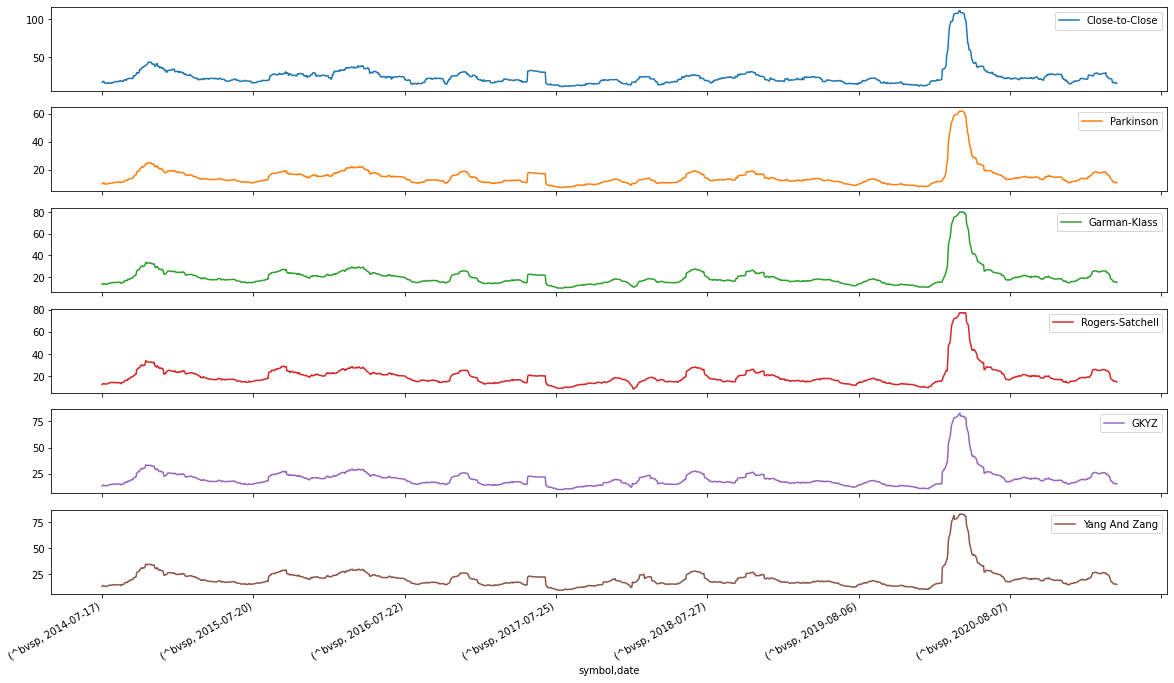

In [22]:
df1.plot(subplots=True, figsize=(20,12)); plt.legend(loc='best')

**Plotando os estimadores em um mesmo gráfico para o período selecionado:**

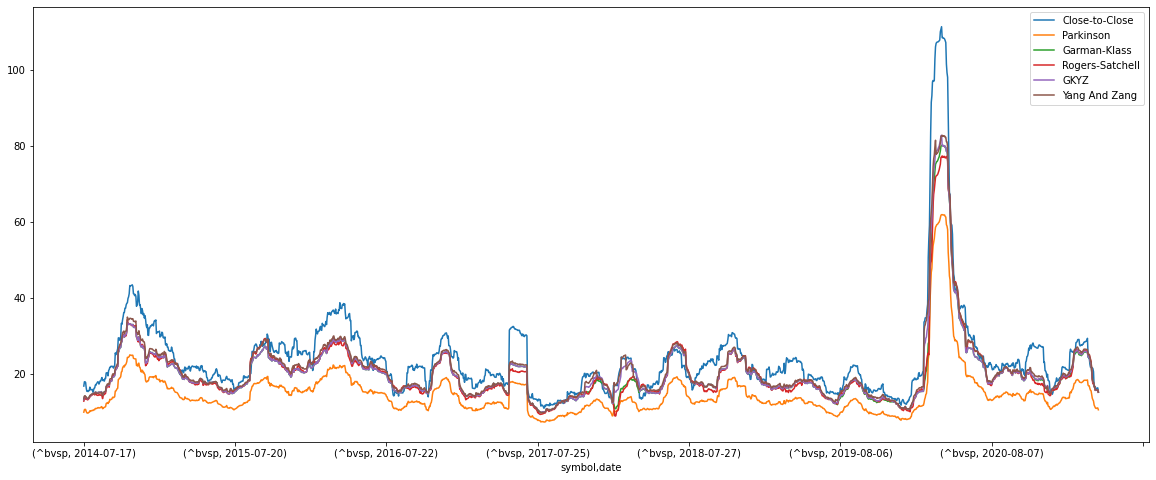

In [23]:
df1.plot(subplots=False, figsize=(20,8)); plt.legend(loc='best')